# Histopathologic Cancer Detection: Check.
In this competition, you must create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates).

PCam is highly interesting for both its size, simplicity to get started on, and approachability. In the authors' words:

[PCam] packs the clinically-relevant task of metastasis detection into a straight-forward binary image classification task, akin to CIFAR-10 and MNIST. Models can easily be trained on a single GPU in a couple hours, and achieve competitive scores in the Camelyon16 tasks of tumor detection and whole-slide image diagnosis. Furthermore, the balance between task-difficulty and tractability makes it a prime suspect for fundamental machine learning research on topics as active learning, model uncertainty, and explainability. 

Challenges
* Normalize staining (https://towardsdatascience.com/image-augmentation-for-deep-learning-using-keras-and-histogram-equalization-9329f6ae5085)
* 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from time import time
from tqdm import tqdm_notebook
import matplotlib

from imgaug import augmenters as iaa


from keras.layers import Input, Dense, Flatten, Conv2D
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard

from skimage import exposure
from generators.augment import augmentor, show_augmentations
from data.data import load_data

In [2]:
BATCH_SIZE = 32
ONLY_USE_SUBSET = True # Set to true when running locally
DIMENSIONS = (96, 96)

## Importing dataset
In this dataset, you are provided with a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. You are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

The original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates. We have otherwise maintained the same data and splits as the PCam benchmark.

In [5]:
(x_train, y_train, meta_train), (x_valid, y_valid, meta_valid), (x_test, y_test, meta_test) = load_data()

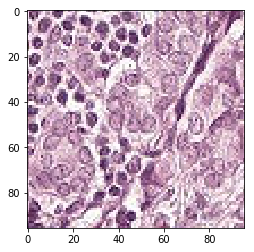

In [45]:
# bit for the image augmentation

# -*- coding: utf-8 -*-
"""
Created on Mon May  6 17:14:07 2019

@author: Stephan
"""

img = np.array(x_train[1])

# Basic image augmentations

''' 
To think about:
    1. In what way does it extend one augmentation extend another?
    2. Do they (randomly) apply augmentation on top of augmentation? or something else?
'''

# Show image
plt.imshow(img)

Text(0.5, 0.98, 'basic augmentations: rotation, fliplr, flipud')

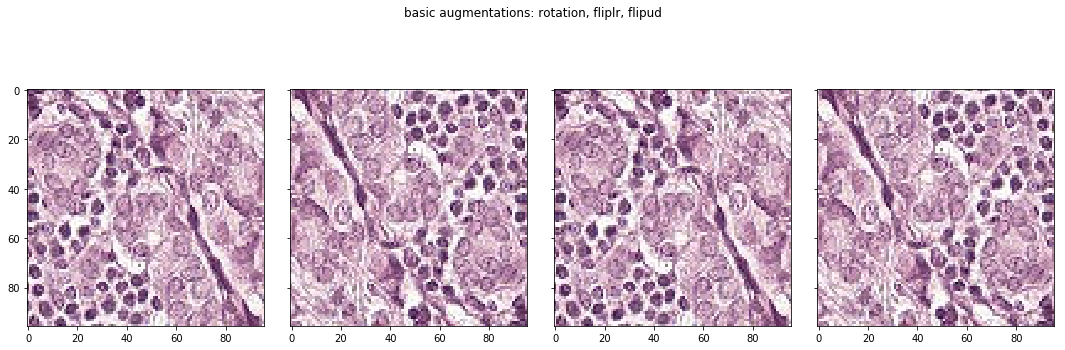

In [69]:
# BASIC DONE
'''
basic: 
    Operations
    ---
        1. 90 degree rotations
        2. horizontal/vertical image mirroring
'''

basic = iaa.OneOf( [iaa.Affine(rotate=90) ,iaa.Fliplr(1), iaa.Flipud(1)])
basic_img = basic.augment_image(img)

fig, axs = plt.subplots(1,4, sharex=True, sharey=True, figsize=(15, 6))
fig.subplots_adjust(hspace = 1.5, wspace=.5)
plt.tight_layout()

for i in range(4):
    axs[i].imshow(basic.augment_image(img))
fig.suptitle('basic augmentations: rotation, fliplr, flipud')    

Text(0.5, 0.98, 'morphology augmentations: Gaussian blur, Add Gaussian, Elastic deformation, Affine scaling')

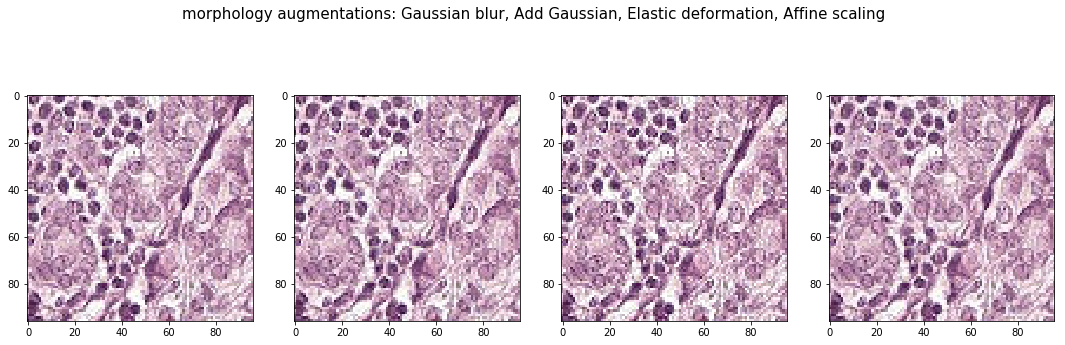

In [59]:
# MORPHOLOGY NEEDS PARAMETER TWEAKING, IMPLEMENTATION IS DONE
'''
Morphology
    Operations
    ---
        1. scaling
        2. elastic deformation
        3. additive Gaussian noise (perturbing the signal-to-noise ratio), 
        4. Gaussian blurring (simulating out-of-focus artifacts).
'''

morphology = iaa.OneOf([iaa.GaussianBlur(sigma=0.35), 
                             iaa.AdditiveGaussianNoise(scale=0.05*255),
                             iaa.ElasticTransformation(alpha=0.35, sigma=0.5),
                             iaa.Affine(scale=(1, 1.5))])

morph_img = morphology.augment_image(img)

fig, axs = plt.subplots(1,4, figsize=(15,6))
fig.subplots_adjust(hspace = 1.5, wspace=.5)
plt.tight_layout()
for i in range(4):
    axs[i].imshow(morphology.augment_image(img))
fig.suptitle('morphology augmentations: Gaussian blur, Add Gaussian, Elastic deformation, Affine scaling', fontsize=15)

Text(0.5, 0.98, 'BC augmentations: Brightness, Contrast')

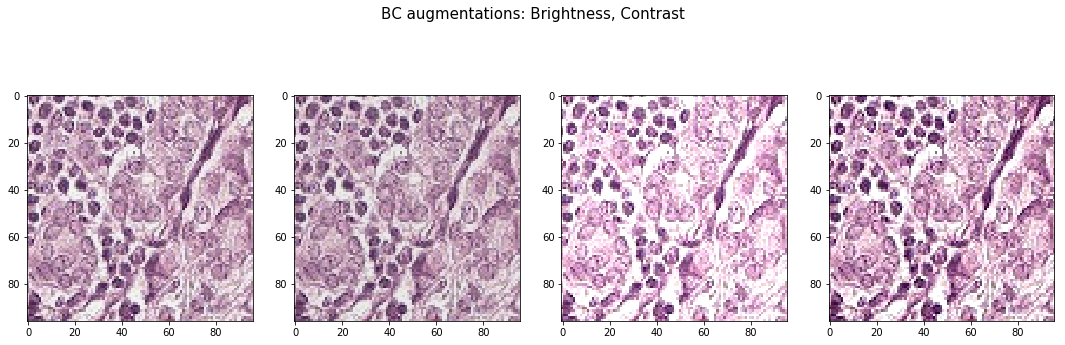

In [64]:
# BC NEEDS PARAMETER TWEAKING
'''
Brightness & Contract (BC)
    Operations
    ---
        1. Random brightness image perturbations
        2. Random contrast image perturbations
        3. Haeberli and Voorhies (1994)
'''

bc = iaa.OneOf([iaa.ContrastNormalization((0.75, 1.25)), 
                     iaa.Multiply((0.5, 1.5))])
bc_img = bc.augment_image(img)

fig, axs = plt.subplots(1,4, figsize=(15,6))
fig.subplots_adjust(hspace = 1.5, wspace=.5)
plt.tight_layout()
for i in range(4):
    axs[i].imshow(bc.augment_image(img))
fig.suptitle('BC augmentations: Brightness, Contrast', fontsize=15)    

Text(0.5, 0.98, 'HSV augmentations: Changing saturation and Value channels')

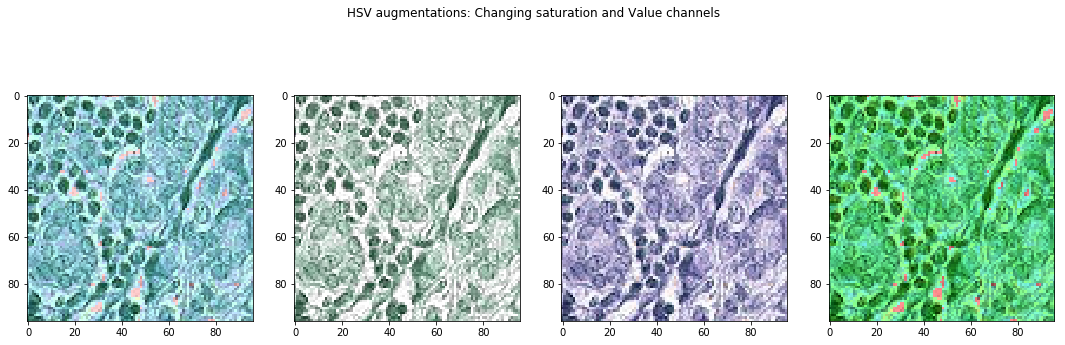

In [67]:
# HSV NEEDS PARAMETER TWEAKING
'''
Hue Saturation Value (HSV)
    Operations
    ---
        1. Randomly shifting hue and saturations channels in the HSV color space
        2. Color variation strength: light and strong
        3. Van der Walt et al. 2014
'''

#Values are kind of extreme

hsv = iaa.WithColorspace(
    to_colorspace="HSV",
    from_colorspace="RGB",
    children=iaa.Sequential([iaa.WithChannels((1), iaa.Add((-100, 150))),
                         iaa.WithChannels((0), iaa.Add((-100, 150)))])
)

hsv_img = hsv.augment_image(img)
fig, axs = plt.subplots(1,4, figsize=(15,6))
fig.subplots_adjust(hspace = 1.5, wspace=.5)
plt.tight_layout()
for i in range(4):
    axs[i].imshow(hsv.augment_image(img))
fig.suptitle('HSV augmentations: Changing saturation and Value channels')    

In [ ]:
# Gathering all together

# Things to change:
# Add OneOf, SomeOf, Sometimes, ... 
# Combine separate augmentations into a probabilitistic augmentation framework
# that combines no operations with possible many segmentations with the following structure:
# 1. Sample image from dataset (normal)
# 2. with probability pb, sample one or more augmentations from the basic set (also with probability)
# 3. With probability pM, sample ... from the Morphology set (one or more is decided at random within one of the imgaug sequences someof, oneof, sometimes, etc...)
# 4. With probability Pb, sample ... (repeat with Bc set of augmentations)
# 5. With probability ph, sample ... from the hsv augmentations.

# This can be achieved using someof, sometimes, oneof, etc...
# Maybe using class representation between the different augmentations?



basic = iaa.OneOf( [iaa.Affine(rotate=90) ,iaa.Fliplr(1), iaa.Flipud(1)])
basic_img = basic.augment_image(img)

morphology = iaa.OneOf([iaa.GaussianBlur(sigma=0.35), 
                             iaa.AdditiveGaussianNoise(scale=0.05*255),
                             iaa.ElasticTransformation(alpha=0.35, sigma=0.5),
                             iaa.Affine(scale=(1, 1.5))])

morph_img = morphology.augment_image(img)


bc = iaa.OneOf([iaa.ContrastNormalization((0.75, 1.25)), 
                     iaa.Multiply((0.5, 1.5))])
bc_img = bc.augment_image(img)

hsv = iaa.WithColorspace(
    to_colorspace="HSV",
    from_colorspace="RGB",
    children=iaa.Sequential([iaa.WithChannels((1), iaa.Add((-100, 150))),
                         iaa.WithChannels((0), iaa.Add((-100, 150)))])
)

hsv_img = hsv.augment_image(img)